In [1]:
import numpy as np
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
kernel_code = """

#define TILE_WIDTH 16

__global__ void MatrixMulKernel(float* d_M, float* d_N, float* d_P, int Width)
{
    __shared__ float Mds[TILE_WIDTH][TILE_WIDTH];
    __shared__ float Nds[TILE_WIDTH][TILE_WIDTH];
    
    int Row = blockIdx.y * TILE_WIDTH + threadIdx.y;
    int Col = blockIdx.x * TILE_WIDTH + threadIdx.x;
    
    int tx = threadIdx.x; int ty = threadIdx.y;

    float Pvalue = 0;

    for (int ph = 0; ph < Width/TILE_WIDTH; ++ph)
    {
        Mds[ty][tx] = d_M[Row*Width + ph*TILE_WIDTH + tx];
        Nds[ty][tx] = d_N[(ph*TILE_WIDTH + ty)*Width + Col];
        __syncthreads();
        for (int k = 0; k < TILE_WIDTH; ++k)
        {
            Pvalue += Mds[ty][k] * Nds[k][tx];
        }
        __syncthreads();
    }
    d_P[Row*Width + Col] = Pvalue; 
}
"""

In [3]:
Cols_Dim = 1024
Rows_Dim = 1024

In [4]:
M = np.random.rand(Rows_Dim, Cols_Dim).astype(np.float32)
N = np.random.rand(Rows_Dim, Cols_Dim).astype(np.float32)

In [5]:
d_M = cuda.mem_alloc(M.nbytes)
d_N = cuda.mem_alloc(N.nbytes)
d_P = cuda.mem_alloc(M.nbytes) # As they are square matrix, output bytes are the same

In [6]:
cuda.memcpy_htod(d_M, M)
cuda.memcpy_htod(d_N, N)

In [7]:
mod = SourceModule(kernel_code)
MatrixMulKernel = mod.get_function("MatrixMulKernel")

In [8]:
block_dim = (16, 16, 1)
grid_dim = ((Cols_Dim + block_dim[0] - 1) // block_dim[0], (Rows_Dim + block_dim[1] - 1) // block_dim[1])

In [9]:
start = time.time()
MatrixMulKernel(
    d_M,
    d_N,
    d_P,
    np.int32(Cols_Dim),
    block = block_dim,
    grid = grid_dim
)
end = time.time()
end - start

0.00099945068359375

In [10]:
P = np.empty_like(M).astype(np.float32)

In [11]:
P.shape

(1024, 1024)

In [12]:
cuda.memcpy_dtoh(P, d_P)

In [13]:
M

array([[0.6679152 , 0.10592703, 0.26474425, ..., 0.91977245, 0.2466563 ,
        0.12611982],
       [0.16977921, 0.5010432 , 0.353344  , ..., 0.80630505, 0.1913338 ,
        0.85592157],
       [0.10025446, 0.32971656, 0.29606226, ..., 0.8849273 , 0.22727858,
        0.5969997 ],
       ...,
       [0.92950624, 0.2219363 , 0.35992387, ..., 0.74274004, 0.29845178,
        0.42759418],
       [0.12382659, 0.64563644, 0.3462829 , ..., 0.5991458 , 0.14450046,
        0.02420733],
       [0.55324244, 0.3630794 , 0.8544967 , ..., 0.6146821 , 0.72303474,
        0.9594718 ]], dtype=float32)

In [14]:
N

array([[6.3142437e-01, 5.3849536e-01, 5.7714766e-01, ..., 7.1352726e-01,
        8.0221188e-01, 6.4098871e-01],
       [7.9329228e-01, 5.9974033e-01, 6.7256141e-01, ..., 9.8937905e-01,
        9.5460719e-01, 6.9591969e-01],
       [9.0011084e-01, 4.6496746e-01, 3.2623118e-04, ..., 1.0017523e-01,
        8.6417228e-02, 2.0480953e-01],
       ...,
       [6.7360866e-01, 8.9728045e-01, 7.2693247e-01, ..., 6.3324399e-02,
        7.9348433e-01, 7.7504516e-02],
       [2.3776276e-02, 6.8800968e-01, 6.1341190e-01, ..., 7.7494133e-01,
        5.5559134e-01, 3.2210636e-01],
       [7.2569287e-01, 5.2297133e-01, 8.4117752e-01, ..., 5.1486525e-03,
        2.6054496e-01, 4.4995427e-01]], dtype=float32)

In [15]:
P

array([[247.0025 , 259.35373, 254.09996, ..., 246.98961, 242.5142 ,
        245.0079 ],
       [257.16092, 254.98154, 254.11777, ..., 257.77832, 255.76958,
        249.19687],
       [261.12256, 257.04037, 257.99966, ..., 258.75635, 258.3597 ,
        254.11215],
       ...,
       [259.92056, 263.1415 , 261.21057, ..., 261.35513, 259.83136,
        253.91042],
       [257.43008, 262.57135, 257.89297, ..., 257.28726, 261.25464,
        256.83798],
       [250.64386, 258.7627 , 251.05354, ..., 259.09766, 253.398  ,
        254.7437 ]], dtype=float32)

In [16]:
start = time.time()
X = np.matmul(M,N).astype(np.float32)
end = time.time()
end - start

0.027005672454833984

In [17]:
X

array([[247.00247, 259.35382, 254.10004, ..., 246.98965, 242.51418,
        245.00812],
       [257.1609 , 254.98163, 254.11774, ..., 257.77853, 255.76947,
        249.19667],
       [261.12244, 257.04037, 257.9996 , ..., 258.7563 , 258.35962,
        254.11217],
       ...,
       [259.92056, 263.1414 , 261.21057, ..., 261.35516, 259.83133,
        253.9104 ],
       [257.43   , 262.5714 , 257.893  , ..., 257.28726, 261.25464,
        256.8381 ],
       [250.64384, 258.76263, 251.05354, ..., 259.09763, 253.39796,
        254.74379]], dtype=float32)

In [18]:
Z = P - X

In [19]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
Z[0,:Rows_Dim]

array([ 0.0000305176, -0.0000915527, -0.0000762939, ..., -0.0000457764,
        0.0000305176, -0.000213623 ], dtype=float32)

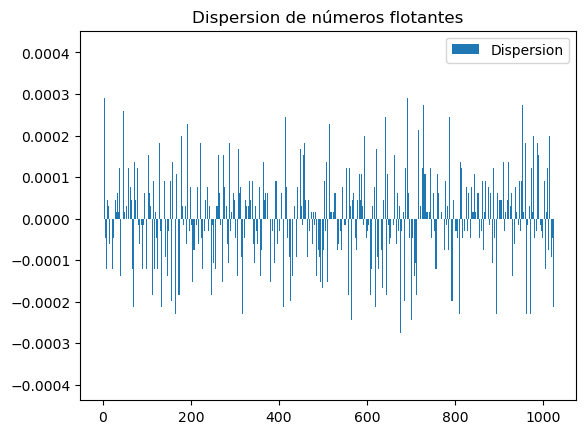

In [20]:
n = Rows_Dim
indices = np.arange(n)
x = np.arange(n)
y = Z[0,:n]
plt.bar(x, y, label='Dispersion')
plt.legend(loc='best')
plt.title('Dispersion de números flotantes')
plt.show()